# Deep Learning
### Week 11: Bayesian neural networks

## Contents

[1. Introduction](#introduction)

[2. The need for uncertainty](#need_for_uncertainty)

[3. Aleatoric uncertainty (\*)](#aleatoric_uncertainty)

[4. Bayesian neural networks](#bnns)

[5. Bayes by Backprop](#bayes_by_backprop)

[6. The DenseVariational layer (\*)](#dense_variational)

[7. MC Dropout](#mc_dropout)

[8. Uncertainty estimation](#uncertainty_estimation)

[References](#references)

<a class="anchor" id="introduction"></a>
## Introduction

In the last week of the module we studied the variational autoencoder (VAE) algorithm, and saw how it can be used for inference and learning in a latent variable generative model. The VAE algorithm optimises a lower bound on the marginal likelihood (or evidence), known as the ELBO. 

You also saw how the VAE can be implemented in TensorFlow and TensorFlow Probability using probabilistic layers from the `layers` module of TFP. One key challenge of the VAE is the approximation of the true posterior distribution.

In this week of the module, we will look at the formulation and implementation of Bayesian neural networks. This is a subfield of probabilistic deep learning that treats the parameters of the network as random variables, and aims to perform inference on them. Therefore, what we are ultimately interested in learning is the posterior distribution over the model parameters, given the data.

A key challenge in the implementation of Bayesian neural networks that is similar to the VAE, is the approximation of the true posterior distribution. We will again use variational inference to approximate the posterior, and in particular two approaches that define parameterised families of distributions for the approximate posterior. These are Bayes by Backprop ([Blundell et al 2015](#Blundell15)) and MC Dropout ([Gal & Ghahramani 2016](#Gal16)).

You will see how these algorithms can be implemented using TensorFlow and TensorFlow probability, and use the approximate posterior distributions to compute the predictive distribution at test time, as well as learning how these distributions can be used to quantify the uncertainty in the predictions.

<a class="anchor" id="need_for_uncertainty"></a>
## The need for uncertainty

One of the main advantages of taking a probabilistic approach to deep learning is that it allows us to account for sources of uncertainty in our modelling process. This is an important point for critical applications, where the negative consequences of inaccurate predictions can be serious, such as autonomous driving, or medical diagnoses. 

Unfortunately, deep learning models are not always accurate, especially when making predictions on new data points that are dissimilar to the data that they were trained on. Worse still, what we often see in this case is that these predictions are overconfident. For example, the neural net might give a very high probability to an incorrect prediction for a data example that is unfamiliar to the model.

We would like our models to be able to assign levels of uncertainty to predictions. However, a first question is what are the main sources of uncertainty that we need to take into account? 

The two categories of uncertainty that we will look at are often referred to as aleatoric and epistemic uncertainty. Aleatoric uncertainty is uncertainty in the data itself. For example, this could come from measurement error, noise in the labels of a dataset. Or it could come down to inherent stochasticity in the data generating process itself. This kind of uncertainty is irreducible in the sense that it represents a randomness in the problem that's always going to be there regardless of the model you use, or the amount of data you collect. We simply have to account for it.

For instance, think of a simple coin flipping experiment. Let's say we have a dataset of the outcomes of a large number of coin tosses. No model is going to be able to predict with certainty what the outcome of the next coin toss is going to be. All we can do is estimate the probability of the coin turning up heads.

Aleatoric uncertainty comes in two flavours: homoscedastic and heteroscedastic. The distinction comes down to whether or not the noise is dependent on the input variable. If the data uncertainty is the same for all target variables, regardless of the input, then it is homoscedastic. If the data uncertainty varies according to the input variable, then it is heteroscedastic.

The other category of uncertainty is epistemic uncertainty, which is model uncertainty. Suppose we design a deep learning model for a problem, and that model has the capacity to model the underlying data distribution accurately. If there isn't enough data available then the model won't be able to learn effectively. In this case, the problem isn't down to randomness in the data, but rather to the uncertainty about which parameter values accurately model the data. In the small data regime, there are potentially many values of the parameters that could explain the data. Epistemic uncertainty is something that will decrease as we gather more data, since the model gets more information about which parameters accurately explain the data.

In the rest of this week, you'll learn methods for designing your deep learning models to account for both aleatoric and epistemic uncertainty.

<a class="anchor" id="aleatoric_uncertainty"></a>
## Aleatoric uncertainty

In this section we will see how we can use probabilistic layers to account for aleatoric uncertainty.

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

We will work with synthetic data $(x_i, y_i)_{i=1}^{1000}$, generated from the following equation:

$$
y_i = x_i^3 + \frac{1}{10}(2 + x_i)\epsilon_i
$$

where $\epsilon_i \sim N(0, 1)$ are independent and identically distributed.

In [11]:
# Generate the data
import numpy as np

x_train = np.linspace(-1,1,1000)
y_train = np.power(x_train,3) + 0.1 * (2+x_train)*np.random.randn(1000)

x_train = x_train[:,None]
y_train = y_train[:,None]

x_train.shape,y_train.shape


((1000, 1), (1000, 1))

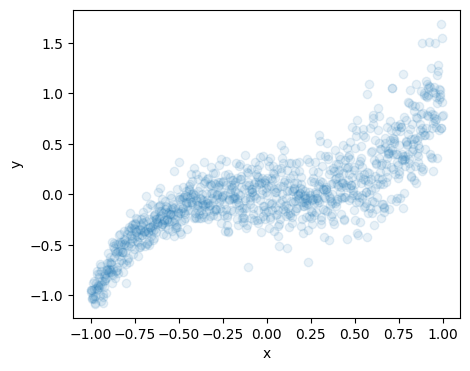

In [12]:
# Plot the data

import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4))
plt.scatter(x_train, y_train, alpha=0.1)
plt.xlabel('x')
plt.ylabel('y')
plt.show()


# HETEROSCEDASTIC AS NOISE INCREASES AS X INCREASES

#### Homoscedastic aleatoric uncertainty
Recall that homoscedastic noise is where the variance does not depend on the input variable.

In [16]:
# Create a model that captures the aleatoric uncertainty with a fixed scale

from keras import Sequential
from keras.layers import Dense

model = Sequential([
    Dense(8,activation = "tanh", input_shape = (1,)),
    #single output neuron
    Dense(1),
    #but we want to output distribution over target variable y
    #so normal with mean depending on input and sd not dep on input as assuming homo
    #lambda t is batch of input, so need to wrap it so normal doesnt have event shape of 2
    tfpl.DistributionLambda(lambda t: tfd.Independent(tfd.Normal(loc = t, scale = 0.5), reinterpreted_batch_ndims = 1))
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 8)                 16        
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
 distribution_lambda_1 (Dist  ((None, 1),              0         
 ributionLambda)              (None, 1))                         
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Examine the distribution output by the model
#outputs a distribution
y = model(tf.constant([[1.0]]))
print(y)
print(y.mean())

tfp.distributions._TensorCoercible("tensor_coercible", batch_shape=[1], event_shape=[1], dtype=float32)
tf.Tensor([[-1.3628016]], shape=(1, 1), dtype=float32)


In [20]:
# Define the NLL loss function

def nll(y_true,y_pred):
    #y true is batch of target labels
    #y pred is batch of prediction distributions
    return - y_pred.log_prob(y_true)


In [21]:
# Compile and train the model using the negative log-likelihood

from keras.optimizers import RMSprop

model.compile(loss = nll, optimizer= RMSprop(learning_rate=0.01))
model.fit(x_train,y_train, epochs = 200, verbose = False)

In [22]:
# Sample model predictions

y = model(x_train)
y_samples = y.sample()

In [23]:
# Compute output means and standard deviations

y_mean = y.mean()
y_std = y.stddev()

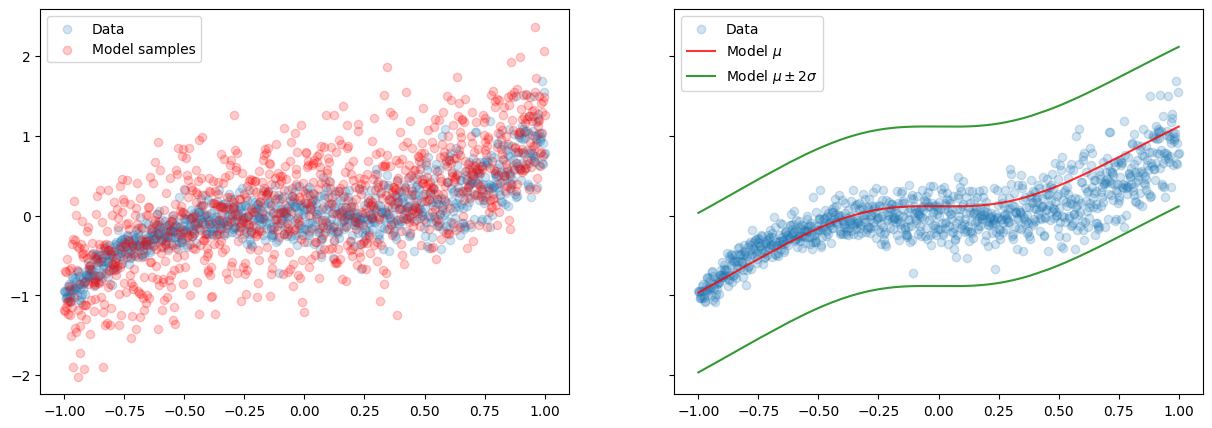

In [24]:
# Plot the data and model samples

y_mean_plus_2std = y_mean - 2 * y_std
y_mean_minus_2std = y_mean + 2 * y_std

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax1.scatter(x_train, y_train, alpha=0.2, label='Data')
ax1.scatter(x_train, y_samples.numpy(), alpha=0.2, color='red', label='Model samples')
ax1.legend()
ax2.scatter(x_train, y_train, alpha=0.2, label='Data')
ax2.plot(x_train, y_mean.numpy(), color='red', alpha=0.8, label=r'Model $\mu$')
ax2.plot(x_train, y_mean_plus_2std.numpy(), color='green', alpha=0.8, label=r'Model $\mu \pm 2 \sigma$')
ax2.plot(x_train, y_mean_minus_2std.numpy(), color='green', alpha=0.8)
ax2.legend()
plt.show()
#overestimates scale since we fixed it so try learn it

In [26]:
# Create a subclassed probabilistic layer

class IndependentNormalFixedScale(tfpl.DistributionLambda):
    
    def __init__(self):
        self.scale = tf.Variable(0., name='scale')
        super().__init__(lambda t: tfd.Independent(tfd.Normal(loc=t,scale=tf.math.exp(self.scale)),
                                                   reinterpreted_batch_ndims=1)) 

In [30]:
# Create a model that captures the aleatoric uncertainty with a learned scale

model = Sequential([
    Dense(8, activation='tanh', input_shape=(1,)),
    Dense(1),
    IndependentNormalFixedScale()
])
model.summary()
#now we have one more parameter to learn but still indep of input

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 8)                 16        
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
 independent_normal_fixed_sc  ((None, 1),              1         
 ale_1 (IndependentNormalFix   (None, 1))                        
 edScale)                                                        
                                                                 
Total params: 26
Trainable params: 26
Non-trainable params: 0
_________________________________________________________________


In [31]:
# Compile and train the model using the negative log-likelihood

model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.01))
model.fit(x_train, y_train, epochs=200, verbose=False)

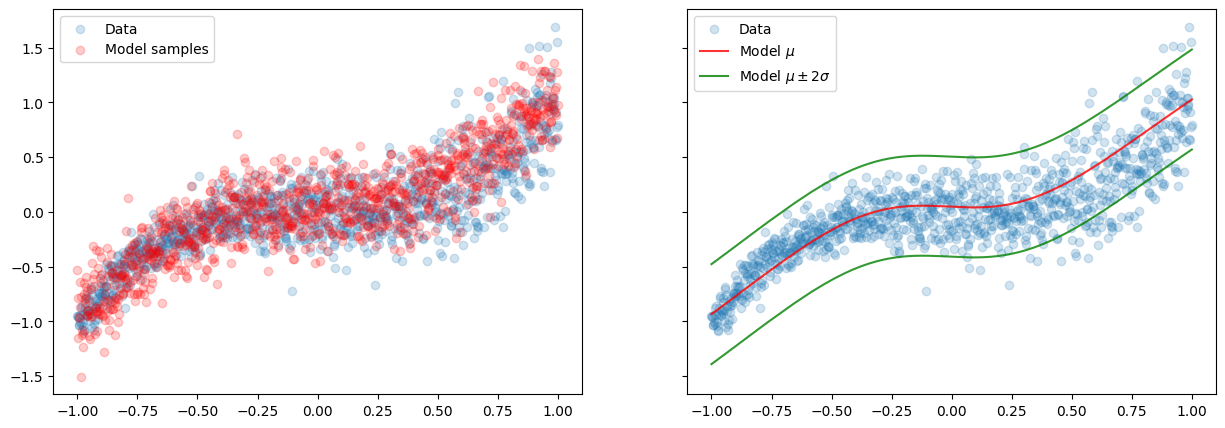

In [32]:
# Plot the data and model samples

y = model(x_train)
y_samples = y.sample()

y_mean = y.mean()
y_std = y.stddev()

y_mean_plus_2std = y_mean - 2 * y_std
y_mean_minus_2std = y_mean + 2 * y_std

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax1.scatter(x_train, y_train, alpha=0.2, label='Data')
ax1.scatter(x_train, y_samples.numpy(), alpha=0.2, color='red', label='Model samples')
ax1.legend()
ax2.scatter(x_train, y_train, alpha=0.2, label='Data')
ax2.plot(x_train, y_mean.numpy(), color='red', alpha=0.8, label=r'Model $\mu$')
ax2.plot(x_train, y_mean_plus_2std.numpy(), color='green', alpha=0.8, label=r'Model $\mu \pm 2 \sigma$')
ax2.plot(x_train, y_mean_minus_2std.numpy(), color='green', alpha=0.8)
ax2.legend()
plt.show()

#### Heteroscedastic aleatoric uncertainty

In [33]:
# Create a model that captures the aleatoric uncertainty

model = Sequential([
    Dense(8, activation='tanh', input_shape=(1,)),
    #set the shape as in last time
    Dense(tfpl.IndependentNormal.params_size(1)),
    #this will automatically paramterize mean and scale using incoming tensor, so both dep on inputs
    tfpl.IndependentNormal(1)
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 8)                 16        
                                                                 
 dense_13 (Dense)            (None, 2)                 18        
                                                                 
 independent_normal (Indepen  ((None, 1),              0         
 dentNormal)                  (None, 1))                         
                                                                 
Total params: 34
Trainable params: 34
Non-trainable params: 0
_________________________________________________________________


In [34]:
# Compile and train the model using the negative log-likelihood

model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.01))
model.fit(x_train, y_train, epochs=200, verbose=False)

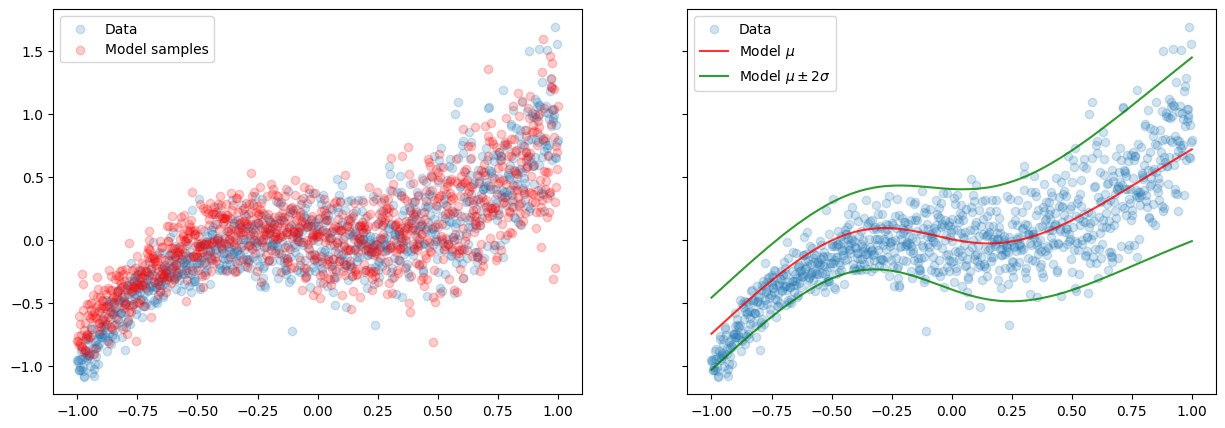

In [35]:
# Plot the data and model samples

y = model(x_train)
y_samples = y.sample()

y_mean = y.mean()
y_std = y.stddev()

y_mean_plus_2std = y_mean - 2 * y_std
y_mean_minus_2std = y_mean + 2 * y_std

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax1.scatter(x_train, y_train, alpha=0.2, label='Data')
ax1.scatter(x_train, y_samples.numpy(), alpha=0.2, color='red', label='Model samples')
ax1.legend()
ax2.scatter(x_train, y_train, alpha=0.2, label='Data')
ax2.plot(x_train, y_mean.numpy(), color='red', alpha=0.8, label=r'Model $\mu$')
ax2.plot(x_train, y_mean_plus_2std.numpy(), color='green', alpha=0.8, label=r'Model $\mu \pm 2 \sigma$')
ax2.plot(x_train, y_mean_minus_2std.numpy(), color='green', alpha=0.8)
ax2.legend()
plt.show()

_Exercise. Create a synthetic dataset of the form $y = f(x) + \epsilon$, so that the noise is independent of the input. Design and train a probabilistic model using the `IndependentNormalFixedScale` layer. How well does the learned scale parameter match the noise level you defined to generate the data?_

<a class="anchor" id="bnns"></a>
## Bayesian neural networks

Up until this point in the course, we have taken the approach of training our models according to the principle of maximum likelihood. This means trying to optimise our deep learning models to find the set of parameters that maximise the likelihood of the data. However, deep learning models often have millions of parameters that we are trying to fit, and maybe only tens of thousands of data points. So it's reasonable to assume that there may be many settings of our parameters that lead to models that fit the data well.

With Bayesian neural networks, what we're ultimately interested in doing is learning a distribution over the parameters of our model that reflects the probability that various settings of the parameters could explain the data. In other words, we treat the network parameters as random variables, and perform inference on them.

By learning this distribution over the model parameters, you can view this as learning an ensemble of deep learning models. We can sample models by sampling from this distribution, each of which should give us a good fit to the data.

By taking this approach, there are two main benefits that we're aiming for. One is improved accuracy - because we're learning a potentially infinite ensemble of networks, if we average our predictions over the ensemble, we might expect that this will improve our predictions. The second typical motivation that people have to look at Bayesian neural networks is uncertainty estimation, or giving the model the ability to quantify how confident it is about its predictions. 

In this week we will first look at popular methods for developing Bayesian neural networks, and then how we can  use these models to quantify different sources of uncertainty.

There are several different approaches to developing Bayesian neural networks that have been proposed in the literature, including the Laplace approximation ([MacKay 1995](#MacKay92)), limiting behaviour in the large width limit ([Neal 1995](#Neal95)), Bayes by Backprop ([Blundell et al 2015](#Blundell15)), MC Dropout ([Gal & Ghahramani 2016](#Gal16)), stochastic weight averaging ([Izmailov et al 2018](#Izmailov18), [Maddox et al 2019](#Maddox19)) and even Deep Ensembles ([Lakshminarayanan et al 2017](#Lakshminarayanan15)) can be viewed as a Bayesian approximation ([Wilson & Izmailov 2020](#Wilson20)). However, the core aims of these approaches are the same: they seek to approximate the posterior distribution over the model parameters, given the data, and assuming a suitable prior distribution. This posterior distribution can then be used to compute the predictive distribution, which means averaging our predictions over networks, where networks are weighted according to the posterior distribution over the parameters.

#### Supervised learning

We will start by briefly reviewing the typical supervised learning setting, where we have a dataset $\mathcal{D} = (x_n, y_n)_{n=1}^N$ of inputs $x_n$ and outputs $y_n$, and we want to model the data with a neural network that depends on parameters $\theta$. We will assume that the network outputs a distribution $p(y \mid x, \theta)$ over predicted values $y$.

The principle we often use to train models like this is maximum likelihood. If we assume our data is i.i.d., then we can write the data likelihood as a product of likelihoods over each data point:

$$
p(\mathcal{D} \mid \theta) = \prod_{n=1}^N p(y_n \mid x_n, \theta),
$$

and so the log-likelihood becomes the sum

$$
\log p(\mathcal{D} \mid \theta) = \sum_{n=1}^N \log p(y_n \mid x_n, \theta).
$$

This is just the log-probability that our model with parameters theta assigns to the dataset. And what we'd like to do is find the parameters that maximise this likelihood. Recall that since the logarithm is a strictly concave function, a given value theta will maximise the likelihood if and only if it also maximises the log-likelihood. So when we optimise the network, we search for the maximum likelihood estimate

$$
\theta_{MLE} = \underset{\theta}{\arg\max} \left[ \log p(\mathcal{D} \mid \theta) \right].
$$

In a first step towards being Bayesian, we might also consider a prior distribution $p(\theta)$, and consider trying to find parameters $\theta$ that maximise the posterior distribution $p(\theta \mid \mathcal{D})$. Remember that the posterior distribution can be calculated according to Bayes' rule

$$
p(\theta | \mathcal{D}) = \frac{p(\mathcal{D} \mid \theta)p(\theta)}{p(\mathcal{D})}.\tag{1}
$$

On the right hand side, we have the likelihood $p(\mathcal{D}\mid\theta)$ multiplied by the prior $p(\theta)$, divided by the marginal likelihood (or model evidence) $p(\mathcal{D})$.

Maximising the posterior $p(\theta\mid\mathcal{D})$ is the same as maximising the log-posterior $\log p(\theta\mid\mathcal{D})$, which we can write as a sum of log terms

$$
\log p(\theta\mid\mathcal{D}) = \log p(\mathcal{D} \mid \theta) + \log p(\theta) - \log p(\mathcal{D}).
$$

The log marginal likelihood $\log p(\mathcal{D})$ doesn't depend on the parameters $\theta$, so maximising the posterior is equivalent to maximising the sum of the log likelihood and the log prior:
$$
\theta_{MAP} = \underset{\theta}{\arg\max} \left[ \log p(\mathcal{D} \mid \theta) + \log p(\theta) \right].
$$

#### Predictive distribution

In Bayesian neural networks, we are interested in computing an approximation to the true posterior distribution $p(\theta \mid \mathcal{D}$. Computing the expression \eqref{posterior_bayes} above is intractable, mainly due to the normalising constant $p(\mathcal{D})$. Computing this term directly would involve evaluating the integral 

$$
\int_{\theta} p(\mathcal{D}\mid\theta)p(\theta) d\theta,
$$

which for all but the most trivial settings has no closed form solution, and is not possible to compute within a reasonable time.

But in principle, if we had access to the posterior $p(\theta\mid\mathcal{D})$, then this would give us some information about the level of uncertainty in our model. For example, if the posterior was very highly concentrated in the parameter space then this would indicate a low level of model uncertainty, whereas if the posterior is very spread out, this could be indicative of high model uncertainty.

We could also use the posterior to average our predictions over all possible models that explain the data. This is what is represented by the predictive distribution

$$
p(y^* \mid x^*, \mathcal{D}) = \int_{\theta} p(y^* \mid x^*, \theta) p(\theta \mid \mathcal{D}) d\theta,\tag{2}
$$

where we use the posterior $p(\theta \mid \mathcal{D})$ to weight the predictions of our model $p(y^* \mid x^*, \theta)$. For a given test input $x^*$, we produce a distribution over target values $y^*$, by computing a Bayesian model average, marginalising out the parameters $\theta$. It's worth emphasising the important difference here to what we normally do when we use deep learning models at test time: instead of using a single set of parameters $\theta$ to produce our predictions, we use all settings of the parameters, weighted by their posterior probabilities.

Since deep learning models are typically under-specified, there will likely be many parameter settings that explain the data, and the posterior is likely to be spread out. All these competing parameter settings correspond to a potentially very diverse range of model hypotheses for the data. That means that there is likely to be a significant difference between the predictions of a single model (with a single set of parameters) and the Bayesian model average over an ensemble of many different but high performing models.

#### Posterior approximation

We can't directly compute the posterior distribution $p(\theta\mid\mathcal{D})$, so we approximate it with a distribution $q_\phi(\theta)$, which itself has parameters $\phi$. The distribution $q$ is the variational distribution, and our objective is to try to optimise its parameters to match it with the true posterior.

Once we've computed our approximate posterior $q$, then we can use this to approximate the predictive distribution:

$$
p(y^* \mid x^*, \mathcal{D}) \approx \int_{\theta} p(y^* \mid x^*, \theta) q_\phi(\theta) d\theta.\tag{3}
$$

Unfortunately, we can't tractably compute this integral either, but we will be able to sample from the distribution $q$, so in practice we'll resort to approximating the predictive distribution with Monte Carlo samples:

$$
p(y^* \mid x^*, \mathcal{D}) \approx \frac{1}{K} \sum_{k=1}^K p(y^* \mid x^*, \theta_k),\qquad \theta_k\sim q_\phi(\theta).\tag{4}
$$

#### Evidence Lower bound (ELBO)

We have now described the setting of the problem, and what we would like to be able to do. The question now is how we go about optimising the parameters $\phi$ in order to match the true posterior $p(\theta\mid\mathcal{D})$ as closely as possible.

We will try to minimise the discrepancy between the variational approximation and the true posterior, as measured by the Kullback-Leibler divergence between $q$ and $p$. We have that

$$
\begin{align}
D_{KL}(q_\phi(\theta) \mid\mid p(\theta\mid\mathcal{D})) &= \mathbb{E}_{q_\phi(\theta)} [\log q_\phi(\theta) - \log p(\theta \mid\mathcal{D}) ] \\
&=  \mathbb{E}_{q_\phi(\theta)} [\log q_\phi(\theta) - \log p(\mathcal{D} \mid\theta) - \log p(\theta) + \log p(\mathcal{D}) ] \\
&= \log p(\mathcal{D}) + \mathbb{E}_{q_\phi(\theta)} [\log q_\phi(\theta) -  \log p(\mathcal{D} \mid\theta) - \log p(\theta) ] \\
&= \log p(\mathcal{D}) - \left\{ \mathbb{E}_{q_\phi(\theta)} [\log p(\mathcal{D}\mid\theta) ] - D_{KL} (q_\phi(\theta) \mid\mid p(\theta) ) \right\}
\end{align}
$$

The term in the curly braces in the last expression is the ELBO. This is a lower bound on the marginal likelihood, since $D_{KL}(q_\phi(\theta) \mid\mid p(\theta\mid\mathcal{D})) \ge 0$ implies that

$$
\begin{align}
ELBO &:= \mathbb{E}_{q_\phi(\theta)} [\log p(\mathcal{D}\mid\theta) ] - D_{KL} (q_\phi(\theta) \mid\mid p(\theta) ) \tag{5} \\
 &\le \log p(\mathcal{D}).
\end{align}
$$

Furthermore, because the model evidence is independent of the distribution $q$, we can also see that minimising the KL divergence between the variational distribution $q$ and the true posterior $p$ is equivalent to maximising the ELBO.

---

In summary, the ELBO expression in the context of Bayesian neural networks is \eqref{bnn_elbo}, which you can think of as a sum of an expected log likelihood under the approximate posterior $q$, and the negative KL-divergence between the approximate posterior $q_\phi(\theta)$ and the prior distribution $p(\theta)$.

This ELBO expression is a lower bound on the model evidence, and minimising the KL divergence between the variational posterior and the true posterior is equivalent to maximising the ELBO. This optimisation is with respect to the choice of variational posterior $q$, which in turn depends on the variational parameters $\phi$. In practice, what we often actually do is minimise the negative ELBO.

This derivation of the ELBO objective is quite similar to what we've seen with the variational autoencoder ([Kingma & Welling 2014](#Kingma14), [Rezende & Mohamed 2015](#Rezende15)), but there are differences. One important difference is that one of the terms of our ELBO expression depends on the data, and the other term doesn't.

The first term $\mathbb{E}_{q_\phi(\theta)} [\log p(\mathcal{D}\mid\theta) ]$ is a data-fitting term. This term captures how well our approximate posterior explains the data $\mathcal{D}$. 

You can think of the second term $- D_{KL} (q_\phi(\theta) \mid\mid p(\theta) )$ as a regularisation term, which measures how far the variational posterior diverges from the prior distribution over the model parameters. This second term doesn't depend on the data at all. 

We'll see later on how this property affects the practical optimisation of the ELBO objective.

<a class="anchor" id="bayes_by_backprop"></a>
## Bayes by Backprop

Bayes by Backprop ([Blundell et al 2015](#Blundell15)) is a popular approach in Bayesian neural networks, which assumes a particular form of the parameterised family of distributions for the variational posterior.

Recall that our maximisation objective is the ELBO:

$$
\mathcal{L}(\phi, \mathcal{D}) := \mathbb{E}_{q_\phi(\theta)} [\log p(\mathcal{D}\mid\theta) ] - D_{KL} (q_\phi(\theta) \mid\mid p(\theta) ) \tag{6} 
$$

Maximising the ELBO is equivalent to minimising the Kullback-Leibler divergence between the approximate and the true posterior. In the context of Bayesian neural networks, the ELBO objective consists of two terms; the first is the expected log likelihood with respect to the approximate posterior. Maximising this term encourages our approximate posterior to fit the data. The second term is a KL-divergence term, which you can think of as a regularisation term. Minimising this term keeps the approximate posterior close to the prior distribution over the model parameters.

An important property of the ELBO to notice is that only the first term depends on the dataset $\mathcal{D}$.

Bayes by backprop refers to a particular choice of the variational family of distributions $q_\phi$. Suppose we are considering a multilayer perceptron model for a supervised learning problem. Our model consists of a number of hidden layers, and weights and biases that parameterise the transformations from layer to layer.

$$
\begin{align}
\mathbf{h}^{(0)} &:= \mathbf{x}, \\
\mathbf{h}^{(k)} &= \sigma\left( \mathbf{W}^{(k-1)}\mathbf{h}^{(k-1)} + \mathbf{b}^{(k-1)} \right),\qquad k=1,\ldots, L,\\
\hat{y} &= \sigma_{out}\left( \mathbf{w}^{(L)}\mathbf{h}^{(L)} + b^{(L)} \right),
\end{align}
$$

where $\mathbf{W}^{(k)}\in\mathbb{R}^{n_{k+1}\times n_k}$, $\mathbf{b}^{(k)}\in\mathbb{R}^{n_{k+1}}$, $\mathbf{h}^{(k)}\in\mathbb{R}^{n_k}$, and we have set $n_0 := D$, and $n_k$ is the number of units in the $k$-th hidden layer.

<img src="figures/mlp.png" style="width: 700px;"/>
<center>A multilayer perceptron model</center>

The collection of model parameters $\theta$ is given by the set of weights and biases:

$$
\theta = \{w^{(k)}_{ij}, b_i^{(k)}\}, \qquad k=0,\ldots,L,\quad i=1,\ldots,n_{k+1},\quad j=1,\ldots,n_k,
$$
where $w^{(k)}_{ij} := (\mathbf{W}^{(k)})_{ij}$ and  $b_i^{(k)} := (\mathbf{b}^{(k)})_i$.

Bayes by backprop makes the choice to use a mean field approximation for the variational posterior. This means that we define the approximate posterior as a fully factorised distribution, so it can be written as the product of individual distributions over each individual weight and bias.

$$
q_\phi(\theta) = \prod_{k=0}^L \left( \prod_{i,j} q_\phi(w_{ij}^{(k)}) \prod_i q_\phi(b_i^{(k)}) \right),
$$

where we are abusing the notation by using the same $q_\phi$ for each of the distributions in these products. In principle these are different distributions for each weight and bias.

In particular, Bayes by backprop chooses to use normal distributions for each one of the distributions in the above expression. So we have

$$
\begin{align}
q_\phi(w_{ij}^{(k)}) = N(w_{ij}^{(k)}; M_{ij}^{(k)}, V_{ij}^{(k)}) \\
q_\phi(b_{i}^{(k)}) = N(b_{i}^{(k)}; m_{i}^{(k)}, v_{i}^{(k)})
\end{align}
$$

Then our variational parameters $\phi$ are the set of mean and variance parameters above:

$$
\phi = \{M^{(k)}_{ij}, V_{ij}^{(k)}, m^{(k)}_{i}, v_{i}^{(k)}\}, \qquad k=0,\ldots,L,\quad i=1,\ldots,n_{k+1},\quad j=1,\ldots,n_k.
$$

These variational parameters are what we want to optimise in order to maximise the ELBO objective \eqref{bbb_elbo}. We would like to optimise our objective function using stochastic gradient descent, or some other gradient-based optimiser. However, our objective function is defined with an expectation over a distribution that depends on the parameters that we want to optimise.

We can use the same reparameterisation trick that we used in the variational autoencoder again here.

To recap how that works, note that our variational posterior $q_\phi(\theta)$ can be reparameterised such that sampling from the variational posterior is equivalent to first sampling an auxiliary noise variable $\epsilon$, and then transforming that noise variable with the deterministic transformation $g_\phi$:

$$
\theta \sim q_\phi(\theta) \qquad \Longleftrightarrow \qquad \epsilon \sim p(\epsilon),\quad \theta = g_\phi(\epsilon).
$$

In particular, we can define the noise distribution $p(\epsilon) = N(\mathbf{0}, \mathbf{I}_P)$ as a diagonal Gaussian with zero mean, and identity covariance matrix. Here $P = |\theta |$ is the total number of weights and biases in our model. We can then just shift and scale our noise sample with mean $\mu$ and standard deviation $\sigma$:

$$
g_\phi(\epsilon) = \mu + \sigma \epsilon,
$$

where $\mu$ and $\sigma$ are given by

$$
\mu = \left[
\begin{array}{c}
\vdots \\
M_{ij}^{(k)} \\
\vdots \\
m_{ij}^{(k)} \\
\vdots
\end{array}
\right],\qquad
\sigma = \left[
\begin{array}{ccccc}
\ddots & 0 & \cdots & 0 & \cdots \\
0 & \sqrt{V_{ij}^{(k)}} & \cdots & 0 & \cdots \\
\vdots & \vdots & \ddots & \vdots & \vdots \\
0 & 0 & \cdots & \sqrt{v_i^{(k)}} & 0 \\
0 & 0 & \cdots & 0 & \ddots
\end{array}
\right]
$$

With this reparameterisation trick, we can rewrite our objective function to use the expectation over the noise distribution instead of the variational posterior. 

$$
\mathcal{L}(\phi, \mathcal{D}) := \mathbb{E}_{p(\epsilon)} [\log p(\mathcal{D}\mid g_\phi(\epsilon)) ] - D_{KL} (q_\phi(\theta) \mid\mid p(\theta) ), \tag{7} 
$$

and now we can take the gradient with respect to $\phi$ inside the expectation.

$$
\nabla_\phi\mathcal{L}(\phi, \mathcal{D}) = \mathbb{E}_{p(\epsilon)} [\nabla_\phi \log p(\mathcal{D}\mid g_\phi(\epsilon)) ] - \nabla_\phi D_{KL} (q_\phi(\theta) \mid\mid p(\theta) ).
$$

Note that if the prior $p(\theta)$ is also chosen to be a Gaussian distribution, then the KL divergence term can be computed analytically. In this case, we can then take gradients of this term with respect to $\phi$ directly.

In practice, we will use an objective function that approximates the ELBO using Monte Carlo samples:

$$
\hat{\mathcal{L}}^B(\phi, \mathcal{D}) := \left[\frac{1}{K} \sum_{j=1}^K \log p(\mathcal{D}\mid g_\phi(\epsilon^{(j)})) \right] - D_{KL} (q_\phi(\theta) \mid\mid p(\theta) ),\qquad \theta^{(j)} = g_\phi(\epsilon^{(j)}),~\epsilon^{(j)}\sim p(\epsilon).\tag{8}
$$

In the above expression we're using $K$ Monte Carlo samples, but in practice people tend to use $K=1$. This is our objective in the case that the KL divergence between the approximate posterior and the prior can be analytically computed.

Of course this might not be the case, and then we would need to approximate the KL divergence term as well. To do that, we can use the fact that

$$
D_{KL}(q_\phi(\theta) \mid\mid p(\theta)) = \mathbb{E}_{p(\epsilon)} [\log q_\phi(g_\phi(\epsilon)) - \log p(g_\phi(\epsilon)) ].
$$

We can use the same reparameterisation trick again here, and our Monte Carlo objective now takes the following form.

$$
\hat{\mathcal{L}}^A(\phi, \mathcal{D}) := \frac{1}{K} \left[ \sum_{j=1}^K \log p(\mathcal{D}\mid g_\phi(\epsilon^{(j)})) -\log q_\phi(\theta^{(j)}) + \log p(\theta^{(j)}) \right],\qquad \theta^{(j)} = g_\phi(\epsilon^{(j)}),~\epsilon^{(j)}\sim p(\epsilon).\tag{9}
$$

One more thing to consider with these objective functions is that the first term is an evaluation of the full dataset likelihood. In practice this isn't feasible to compute except for very small datasets, and we'll need to use minibatches in our training run as usual.

However, we need to be a bit careful with how to compute our objective when using minibatches. Remember that only the first term in our objective depends on the dataset, and the KL divergence is independent of the data. This is true for both forms of our objective \eqref{bbb_elbo_reparam_b} and \eqref{bbb_elbo_reparam_a}.

So if we only compute the data likelihood over a minibatch, then we need to scale up the minibatch likelihood so that it's an unbiased estimator of the full data likelihood.

$$
\hat{\mathcal{L}}^A(\phi, \mathcal{D}_m) := \frac{1}{K} \sum_{j=1}^K  \left[ \frac{N}{M} \log p(\mathcal{D}_m\mid g_\phi(\epsilon^{(j)})) -\log q_\phi(\theta^{(j)}) + \log p(\theta^{(j)}) \right],\qquad \theta^{(j)} = g_\phi(\epsilon^{(j)}),~\epsilon^{(j)}\sim p(\epsilon)
$$
$$
\hat{\mathcal{L}}^B(\phi, \mathcal{D}_m) := \left[\frac{1}{K} \cdot \frac{N}{M} \sum_{j=1}^K \log p(\mathcal{D}_m\mid g_\phi(\epsilon^{(j)})) \right] - D_{KL} (q_\phi(\theta) \mid\mid p(\theta) ),\qquad \theta^{(j)} = g_\phi(\epsilon^{(j)}),~\epsilon^{(j)}\sim p(\epsilon)
$$

In the above, $\mathcal{D}_m$ indicates a minibatch of data, $|\mathcal{D}_m| = M$, and $N$ is the size of the full dataset. Again in practice, because we usually compute average data log-likelihoods over a minibatch, it's more convenient to work with the following scaled version of the objective.

$$
\hat{\mathcal{L}}^A(\phi, \mathcal{D}_m) := \frac{1}{K} \sum_{j=1}^K  \left[ \frac{1}{M} \log p(\mathcal{D}_m\mid g_\phi(\epsilon^{(j)})) - \frac{1}{N} \left( \log q_\phi(\theta^{(j)}) + \log p(\theta^{(j)}) \right) \right],\qquad \theta^{(j)} = g_\phi(\epsilon^{(j)}),~\epsilon^{(j)}\sim p(\epsilon)\tag{10}
$$
$$
\hat{\mathcal{L}}^B(\phi, \mathcal{D}_m) := \left[\frac{1}{K} \cdot \frac{1}{M} \sum_{j=1}^K \log p(\mathcal{D}_m\mid g_\phi(\epsilon^{(j)})) \right] - \frac{1}{N} D_{KL} (q_\phi(\theta) \mid\mid p(\theta) ),\qquad \theta^{(j)} = g_\phi(\epsilon^{(j)}),~\epsilon^{(j)}\sim p(\epsilon)\tag{11}
$$

The first term in both \eqref{bbb_elbo_reparam_a_minibatch} and \eqref{bbb_elbo_reparam_b_minibatch} is now an average log-likelihood over the minibatch (as we normally compute), and the KL-divergence terms have a weighting of $1/N$. These final two expressions are the objectives that are typically implemented for the Bayes by Backprop algorithm.

<a class="anchor" id="dense_variational"></a>
## The DenseVariational layer

In this section we will see how the Bayes by Backprop algorithm can be implemented with use of the `DenseVariational` probabilistic layer.

In [36]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

We will continue to work with synthetic data $(x_i, y_i)_{i=1}^{1000}$, generated from the following equation:

$$
y_i = x_i^3 + \frac{1}{10}(2 + x_i)\epsilon_i
$$

where $\epsilon_i \sim N(0, 1)$ are independent and identically distributed.

In [37]:
# Generate the data

import numpy as np

x_train = np.linspace(-1, 1, 1000)
y_train = np.power(x_train, 3) + 0.1*(2+x_train)*np.random.randn(1000)

x_train = np.expand_dims(x_train, -1)
y_train = np.expand_dims(y_train, -1)

In [43]:
# Define the prior function

#needs specific signature to work with dense variational layer:

#should return callable object, receiving input tensor to dense layer and return distribution object defining prior
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return lambda t: tfd.MultivariateNormalDiag(loc=tf.zeros(n, dtype=dtype),
                                                scale_diag=tf.ones(n, dtype=dtype))

In [40]:
# Define the posterior function

from tensorflow.keras import Sequential


#again same signature, returning callable
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = Sequential([
        #variable layer returns a tensorflow variable when called
        tfpl.VariableLayer(tfpl.IndependentNormal.params_size(n), dtype=dtype),
        #convert to tensor argument is implicilty used (this option is the default)
        tfpl.IndependentNormal(n, convert_to_tensor_fn=tfd.Distribution.sample)
    ])
    return posterior_model

In [44]:
# Create a model that captures the aleatoric uncertainty

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

N = x_train.shape[0]

#replace dense with densevariational, needs prior etc
model = Sequential([
    tfpl.DenseVariational(8, activation='tanh', input_shape=(1,),make_prior_fn=prior, make_posterior_fn=posterior, kl_weight=1/N),
    #kl use exact false by default, so we do MC so need the distribution sample thing above, if true then posterior and prior need to result in closed form
    tfpl.DenseVariational(tfpl.IndependentNormal.params_size(1),make_prior_fn=prior, make_posterior_fn=posterior, kl_weight=1/N,kl_use_exact = False),
    tfpl.IndependentNormal(1)
])
model.summary()
#params doubled since now learning mean and scale param for each individual param in network

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_variational (DenseVar  (None, 8)                32        
 iational)                                                       
                                                                 
 dense_variational_1 (DenseV  (None, 2)                36        
 ariational)                                                     
                                                                 
 independent_normal_2 (Indep  ((None, 1),              0         
 endentNormal)                (None, 1))                         
                                                                 
Total params: 68
Trainable params: 68
Non-trainable params: 0
_________________________________________________________________


Recall the Bayes by Backprop objective (with or without the exact KL-divergence term):

$$
\hat{\mathcal{L}}^A(\phi, \mathcal{D}_m) := \frac{1}{K} \sum_{j=1}^K  \left[ \frac{1}{M} \log p(\mathcal{D}_m\mid g_\phi(\epsilon^{(j)})) - \frac{1}{N} \left( \log q_\phi(\theta^{(j)}) + \log p(\theta^{(j)}) \right) \right],\qquad \theta^{(j)} = g_\phi(\epsilon^{(j)}),~\epsilon^{(j)}\sim p(\epsilon)
$$
$$
\hat{\mathcal{L}}^B(\phi, \mathcal{D}_m) := \left[\frac{1}{K} \cdot \frac{1}{M} \sum_{j=1}^K \log p(\mathcal{D}_m\mid g_\phi(\epsilon^{(j)})) \right] - \frac{1}{N} D_{KL} (q_\phi(\theta) \mid\mid p(\theta) ),\qquad \theta^{(j)} = g_\phi(\epsilon^{(j)}),~\epsilon^{(j)}\sim p(\epsilon)
$$

In [ ]:
# Define the NLL loss function

#KL divergence term is added by densevariational layer

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

In [45]:
# Compile and fit the model

from tensorflow.keras.optimizers import RMSprop

model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.01))
history = model.fit(x_train, y_train, epochs=300, verbose=False)

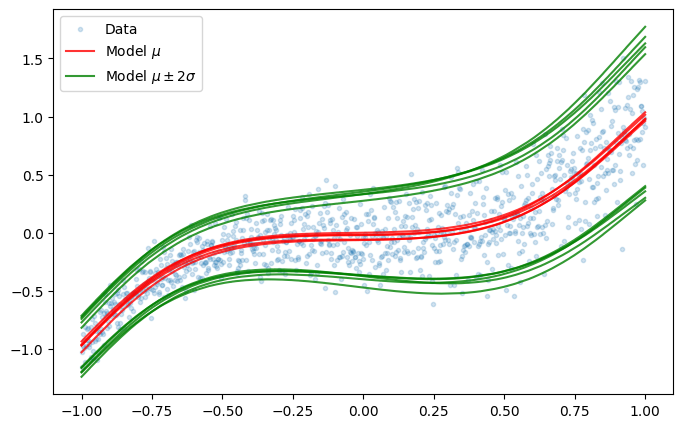

In [53]:
# Plot the data and an ensemble of model predictions

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.scatter(x_train, y_train, marker='.', alpha=0.2, label='Data')

ensemble_size = 5

for i in range(ensemble_size):
    y = model(x_train)
    y_mean = y.mean().numpy()
    y_std = y.stddev().numpy()
    y_mean_plus_2std = y_mean - 2 * y_std
    y_mean_minus_2std = y_mean + 2 * y_std
    if i == 0:
        plt.plot(x_train, y_mean, color='red', alpha=0.8, label='Model $\mu$')
        plt.plot(x_train, y_mean_plus_2std, color='green', alpha=0.8, label='Model $\mu \pm 2 \sigma$')
        plt.plot(x_train, y_mean_minus_2std, color='green', alpha=0.8)
    else:
        plt.plot(x_train, y_mean, color='red', alpha=0.8)
        plt.plot(x_train, y_mean_plus_2std, color='green', alpha=0.8)
        plt.plot(x_train, y_mean_minus_2std, color='green', alpha=0.8)        
plt.legend()
plt.show()
plt.show()

_Exercise. There are also equivalent probabilistic layers for convolutions, see [`tfp.layers.Convolution1DReparameterization`](https://www.tensorflow.org/probability/api_docs/python/tfp/layers/Convolution1DReparameterization), [`tfp.layers.Convolution2DReparameterization`](https://www.tensorflow.org/probability/api_docs/python/tfp/layers/Convolution2DReparameterization) and [`tfp.layers.Convolution3DReparameterization`](https://www.tensorflow.org/probability/api_docs/python/tfp/layers/Convolution3DReparameterization). The API for these layers is similar to the `DenseVariational` layer. Look through the docs and try to implement a Bayesian CNN using one of these probabilistic layers._

<a class="anchor" id="mc_dropout"></a>
## MC Dropout

In this section, we will go through an approach to Bayesian neural network modelling known as MC Dropout ([Gal & Ghahramani 2016](#Gal16)). We have seen Dropout already earlier in the course, and it is very commonly used in neural network training. As we'll see, there is a nice Bayesian interpretation for training regularised neural networks with dropout, which motivates the use of dropout at test time as well as in training.

To recap the problem setting: we assume a prior distribution $p(\theta)$ over the model weights, and given the dataset $\mathcal{D}$, we would like to approximate the true posterior given the data $p(\theta\mid\mathcal{D})$, with a variational distribution $q_\phi(\theta)$.

We choose to minimise the Kullback-Leibler divergence $D_{KL}(q_\phi(\theta) \mid\mid p(\theta\mid\mathcal{D}))$, which turns out to be equivalent to maximising the ELBO objective

$$
\mathcal{L}(\phi, \mathcal{D}) = \mathbb{E}_{q_\phi(\theta)} [ \log p(\mathcal{D}\mid\theta)] - D_{KL}(q_\phi(\theta)\mid\mid p(\theta))\tag{12}
$$

We can view the ELBO objective as the sum of two terms, the first of which tries to maximise the expected log-likelihood of the dataset under our variational distribution $q_\phi$, and the second term is the negative KL-divergence between $q_\phi(\theta)$ and the prior $p(\theta)$, which regularises $q_\phi$ so that it doesn't diverge too far from the prior. Recall that only the first of these two terms depends on the dataset $\mathcal{D}$.

We will again assume a diagonal Gaussian distribution for the prior, with zero mean and identity covariance matrix.

#### Dropout

Dropout is usually introduced as a training technique, where weight connections in the network are randomly dropped out according to some fixed probability. 

<img src="figures/dropout.png" alt="Dropout" style="width: 700px;"/>
<center>Neural network with dropout</center>

This has a regularisation effect on the network, but perhaps more importantly encourages robustness of features learned by the network. 

Let's consider that we're modelling our data with a multilayer perceptron with $L$ hidden layers and denote $\mathbf{W}^{(k)}$ to be the weight matrix that define the transformation from hidden layer $k$ to hidden layer $k+1$, and similarly for the bias terms $\mathbf{b}^{(k)}$.

$$
\mathbf{h}^{(k+1)} = \sigma\left( \mathbf{W}^{(k)}\mathbf{h}^{(k)} + \mathbf{b}^{(k)} \right)
$$

Also define $n_k$ to be the number of neurons in layer $k$ where the input layer is the zero-th layer. Then the matrix $\mathbf{W}^{(k)}$ has shape $n_{k+1}\times n_k$, and $\mathbf{b}^{(k)}$ is a vector of length $n_{k+1}$.

There are two equivalent ways of thinking about dropout: either as randomly dropping out neurons within a hidden layer, or by randomly dropping out the weight connections between hidden layers. We're going to be thinking of the latter, so the dropout technique can be summarised as follows: 

$$
\begin{align}
\mathbf{W}^{(k)} &\leftarrow \mathbf{W}^{(k)} \cdot\text{diag} ([\mathbf{z}_{k, j}]_{j=1}^{n_{k-1}})\\
\mathbf{z}_{k, j} &\sim \text{Bernoulli}(p_k), \qquad k=0,\ldots, L,
\end{align}
$$

On each pass through the network, we multiply the weight matrix $\mathbf{W}^{(k)}$ by a diagonal matrix $\text{diag} ([\mathbf{z}_{k, j}]_{j=1}^{n_{k-1}})$, where the diagonal elements are each independently sampled from a Bernoulli distribution with probability $p_k$. This has the effect of randomly dropping out columns of the matrix $\mathbf{W}^{(k)}$, independently with probability $1 - p_k$. In this notation, $p_k$ is the keep rate, whereas the dropout rate is $1 - p_k$.

Note that we are introducing dropout into all of the weight connections of the network, including the first set of weights that maps the inputs $\mathbf{x}$ to the first hidden layer. Usually you wouldn't use dropout on the input layer, which is what you see in the diagram above, but this really depends on the nature of the data. If dropout is not being used on $\mathbf{W}^{(0)}$, then this is equivalent to setting $p_0=1$. 

The insight here is that dropout can be viewed as inducing a distribution over the model weights. And since the columns of each weight matrix $\mathbf{W}^{(k)}$ are dropped out independently, this is a highly multimodal distribution. 

#### Variational distribution

We will denote the parameters of the model 

$$
\theta = \left\{\mathbf{W}^{(k)}_j, \mathbf{b}^{(k)} \right\},
$$ 

where $\mathbf{W}^{(k)}_j \in\mathbb{R}^{n_{k+1}}$ is the $j$-th column of $\mathbf{W}^{(k)}$, and $\mathbf{b}^{(k)}\in\mathbb{R}^{n_{k+1}}$ is the bias vector for the $k$-th hidden layer.

In MC Dropout, we will use the dropout distribution as the variational distribution $q_\phi$. In this case, we could write our variational distribution $q_\phi$ as follows:

$$
q_\phi(\theta) = \prod_{k=0}^L \delta(\mathbf{b}^{(k)} = \mathbf{m}^{(k)}) \prod_{j=1}^{n_k} \left ( p_k \delta(\mathbf{W}_j^{(k)} = \mathbf{M}_j^{(k)}) + (1-p_k) \delta(\mathbf{W}_j^{(k)} = \mathbf{0})\right)\tag{13}
$$

We are not applying dropout to the bias terms, so we can write this as a delta distribution, where the bias vector $\mathbf{b}^{(k)}$ is fixed to the value $\mathbf{m}^{(k)}$. For the weight matrix $\mathbf{W}^{(k)}$, we can write the dropout distribution as a weighted sum of delta distributions, weighted by the keep rate $p_k$. With probability $p_k$, the $j$-th column of the weight matrix $\mathbf{W}^{(k)}$ will equal the vector value $\mathbf{M}_j^{(k)}$, and with probability $1 - p_k$, the $j$-th column of $\mathbf{W}^{(k)}$ will be zeros.

So now $\mathbf{M}_j^{(k)}$ and $\mathbf{m}^{(k)}$ ($k=0,\ldots,L$, $j=1,\ldots,n_k$) are our variational parameters, that we'd like to optimise:

$$
\phi = \left\{ \mathbf{M}_j^{(k)}, \mathbf{m}^{(k)} \right\}_{j, k}.
$$

We would like to optimise our ELBO objective \eqref{mc_dropout_elbo} with a gradient-based optimiser as usual, but we have the same problem that the objective contains an expectation over the distribution $q_\phi$, which depends on the variational parameters $\phi$. We can use the same reparameterisation trick again here that we used before.

We introduce the auxiliary noise variable $\epsilon$ as the collection of noise variables

$$
\epsilon = \left\{ \epsilon_j^{(k)} \right\}_{j, k},\qquad \epsilon^{(k)}_j \sim \text{Bernoulli}(p_k),\tag{14}
$$

where again $k=0,\ldots,L$ indexes the layers and $j=1,\ldots,n_k$ indexes the neurons in each layer. We can also write the transformation 

$$
g_\phi(\epsilon) = \left\{ g_{\phi,j}^{(k)}(\epsilon) \right\}_{j, k},\qquad g_{\phi,j}^{(k)}(\epsilon) = \left( \epsilon_j^{(k)}\mathbf{M}^{(k)}_j, \mathbf{m}^{(k)} \right).\tag{15}
$$

Then sampling $\theta$ from the variational distribution $q_\phi$ is equivalent to first sampling a noise variable $\epsilon$, and then transforming the noise variable with the transformation $g_\phi$:

$$
\theta \sim q_\phi(\theta) \quad \Longleftrightarrow \quad \epsilon\sim p(\epsilon),\quad \theta = g_\phi(\epsilon).\tag{16}
$$

With this reparameterisation, we can rewrite our objective function \eqref{mc_dropout_elbo} in the following form:

$$
\mathcal{L}(\phi, \mathcal{D}) = \mathbb{E}_{p(\epsilon)} [ \log p(\mathcal{D}\mid g_\phi(\epsilon))] - D_{KL}(q_\phi(\theta)\mid\mid p(\theta)),\tag{17}
$$

so that the expectation is now being taken with respect to the noise distribution $p(\epsilon)$, which means that we can take the gradient with respect to $\phi$ inside the expectation:

$$
\nabla_\phi\mathcal{L}(\phi, \mathcal{D}) = \mathbb{E}_{p(\epsilon)} [\nabla_\phi \log p(\mathcal{D}\mid g_\phi(\epsilon)) ] - \nabla_\phi D_{KL} (q_\phi(\theta) \mid\mid p(\theta) ).
$$

Remember that the probabilities $p_k$ are fixed and are not part of our variational parameters, so it's not a problem that the noise distribution depends on these. 

#### KL-divergence term

With the above approach, we can approximate and optimise the first term of the ELBO objective, but there is a problem with the KL-divergence term. The problem is that the KL divergence is not actually not defined, which is due to the fact that our variational distribution is defined in terms of delta measures. The technical issue is that the variational distribution $q_\phi(\theta)$ is not absolutely continuous with respect to the prior distribution $p(\theta)$. Absolute continuity of measures is defined as follows.

**Definition.** _A measure $\mu$ is absolutely continuous with respect to the measure $\lambda$ if for for every set $A$ with $\lambda(A) = 0$, we have $\mu(A)=0$._

In our case, the above condition is not satisfied for the distributions $q_\phi(\theta)$ and $p(\theta)$. For example, we can define the (single) set of parameter values

$$
A = \left\{ \left\{ \mathbf{M}_j^{(k)} \right\}, \left\{ \mathbf{m}^{(k)} \right\} \right\}_{j, k},\qquad k=0,\ldots,L, \quad j=1,\ldots,n_k
$$

and we have $\int_A q_\phi(\theta) d\theta = (p_k)^{Ln_k}$. However, $A$ is a single point in the continuous parameter space $\theta$, and the prior $p(\theta)$ is a Gaussian distribution. Therefore we have $\int_A p(\theta) d\theta = 0$, and the condition for absolute continuity is violated.

Absolute continuity of measures is a technical condition that we need in order for the KL divergence to be defined. In our case, this condition is broken, so the KL-divergence term in our objective \eqref{mc_dropout_elbo_reparam} is undefined. Another way to think about this is that the KL divergence term blows up with this choice of prior and variational posterior.

#### Gaussian mixture variational posterior

The solution the authors of the original paper took was to replace the dropout distribution with something similar; namely the following mixture of Gaussian distributions:

$$
q_\phi(\theta) = \prod_{k=0}^L N(\mathbf{b}^{(k)}; \mathbf{m}^{(k)}, \sigma^2\mathbf{I}_{n_{k+1}}) \prod_{j=1}^{n_k} \left ( p_k N(\mathbf{W}_j^{(k)}; \mathbf{M}_j^{(k)}, \sigma^2\mathbf{I}_{n_{k+1}}) + (1-p_k) N(\mathbf{W}_j^{(k)}; \mathbf{0}, \sigma^2\mathbf{I}_{n_{k+1}})\right)\tag{18}
$$

where the weight matrix columns $\mathbf{W}_j^{(k)}$ are distributed according to a mixture of two Gaussians with means equal to $\mathbf{M}^{(k)}_j$ and zero, and with a diagonal covariance matrix with a small variance $\sigma^2$. These Gaussians are weighted by the probabilities $p_k$. The bias vectors are distributed according to a (single) Gaussian distribution with mean located at $\mathbf{m}^{(k)}$, and with the same diagonal covariance matrix with variance $\sigma^2$.

This variational posterior is in a sense fattening out the dropout delta distributions that we had before (see \eqref{mc_dropout_q_phi_bernoulli}). If we fix $\sigma^2$ to some small value, then this is a reasonable approximation of the dropout distribution \eqref{mc_dropout_q_phi_bernoulli}. 

We can still use the reparameterisation trick in a similar way with this variational posterior. This time, we define the collection of auxiliary noise variables (cf. \eqref{mc_dropout_noise_variables_bernoulli})

$$
\epsilon := \left\{\hat{\epsilon}_j^{(k)}, \tilde{\epsilon}_{W,j}^{(k)}, \tilde{\epsilon}_{b,j}^{(k)} \right\}_{j,k} \qquad \hat{\epsilon}_j^{(k)} \sim\text{Bernoulli}(p_k),\quad  \tilde{\epsilon}_{W,j}^{(k)} \sim N(\mathbf{0},\sigma^2\mathbf{I}_{n_{k+1}}),\quad \tilde{\epsilon}_{b,j}^{(k)} \sim N(\mathbf{0},\sigma^2\mathbf{I}_{n_{k+1}}),\tag{19}
$$

and then we can define our transformation $g_\phi(\epsilon)$ as follows (cf. \eqref{mc_dropout_transformation_bernoulli}):

$$
g_\phi(\epsilon) = \left\{ g_{\phi,j}^{(k)}(\epsilon) \right\}_{j,k},\qquad g_{\phi,j}^{(k)}(\epsilon) := \left( \hat{\epsilon}_j^{(k)} \mathbf{M}_j^{(k)} + \tilde{\epsilon}_{W,j}^{(k)}, \mathbf{m}^{(k)} + \tilde{\epsilon}_{b,j}^{(k)} \right)\tag{20}
$$

With this reparameterisation, sampling $\theta$ from $q_\phi$ is equivalent to first sampling $\epsilon$ from the noise distribution (this time defined as the collection of Bernoulli and Gaussian distributions in \eqref{mc_dropout_noise_variables_gaussian}), and then transforming $\epsilon$ with $g_\phi$.

$$
\theta \sim q_\phi(\theta) \quad \Longleftrightarrow \quad \epsilon\sim p(\epsilon),\quad \theta = g_\phi(\epsilon)
$$

In practice we would approximate the expectation in \eqref{mc_dropout_elbo_reparam} with Monte Carlo samples, so the objective becomes

$$
\hat{\mathcal{L}}^B(\phi, \mathcal{D}) := \left[ \frac{1}{K} \sum_{j=1}^K \log p(\mathcal{D} \mid \theta^{(j)}) \right] - D_{KL}(q_\phi(\theta) \mid\mid p(\theta))\tag{21}
$$

In practice, most implementations use $K=1$. The $\theta^{(j)}$ in the above is given by the transformation $g_\phi(\epsilon^{(j)})$, where $\epsilon^{(j)} \sim p(\epsilon)$.

Note that this corresponds to how we usually think of using dropout. We sample weights from the approximate dropout distribution, then run the forward and backward pass of the network using these weight values, compute the gradients and update the parameters.

With this variational distribution the KL-divergence is now defined: the mixture of Gaussians variational posterior $q_\phi(\theta)$ is now absolutely continuous with respect to the prior $p(\theta)$. But we can't compute the KL-divergence term analytically, as there's no closed form expression for the KL-divergence between a mixture of Gaussians and a single Gaussian, so we have to approximate this term.

The following proposition is reproduced from the original paper ([Gal & Ghahramani 2016](#Gal16)). 

**Proposition.** _Fix $K, L\in\mathbb{N}$, a probabilitiy vector $\mathbf{p} = (p_1,\ldots, p_L)$, and $\Sigma_i\in\mathbb{R}^{K\times K}$ positive-definite for $i=1,\ldots,L$, with the elements of each $\Sigma_i$ not dependent on $K$. Let
$$
q(\mathbf{x}) = \sum_{i=1}^L p_i N(\mathbf{x}; \mathbf{\mu}_i, \Sigma_i)
$$
be a mixture of Gaussians with $L$ components and $\mathbf{\mu}_i\in\mathbb{R}^K$ normally distributed, and let $p(\mathbf{x}) = N(0,\mathbf{I}_K)$._

_The KL divergence between $q(\mathbf{x})$ and $p(\mathbf{x})$ can be approximated as:
$$
D_{KL}(q(\mathbf{x}) \mid\mid p(\mathbf{x})) \approx \sum_{i=1}^L \frac{p_i}{2} (\mu_i^T \mu_i + \text{tr}(\Sigma_i) - K(1 + \log 2\pi) - \log |\Sigma_i|)
$$
plus a constant for large enough $K$._

The statement of the proposition says that if we have a distribution $q$ which is a mixture of $L$ Gaussians, each weighted with probabilities $p_i$, and with means $\mu_i$ and covariance matrix $\Sigma_i$, and if the distribution $p$ is a zero mean Gaussian with identity covariance matrix, then the KL divergence can be approximated with the above expression, up to some additive constant. This approximation is good for large $K$, where $K$ is the dimension of the Gaussian distributions above. 

In our case, $K$ corresponds to the widths of the hidden layers. So if our hidden layers are sufficiently wide, then we can replace the KL divergence term in our ELBO objective with expressions of this form. In this case, the KL divergence term in the ELBO objective can be approximated as

$$
D_{KL}(q_\phi(\theta) \mid\mid p(\theta)) \approx \sum_{k=0}^L (n_k + 1)n_{k+1} (\sigma^2 - \log (\sigma^2) - 1) + \frac{p_k}{2}\sum_{j=1}^{n_k} \left|\left| \mathbf{M}_j^{(k)} \right|\right|^2_2 + \frac{1}{2} \left|\left| \mathbf{m}^{(k)} \right|\right|^2_2 + C.\tag{22}
$$

The above is a sum over the layers of the network (recall $n_k$ and $n_{k+1}$ are referring to the widths of the layers), $\sigma^2$ is the variance of the Gaussians in our variational posterior mixture distribution, the $p_k$ are the keep probabilities, and $\mathbf{M}_j^{(k)}$ and $\mathbf{m}^{(k)}$ are the variational parameters that are the means of the Gaussian distributions over the weights and biases of the network. $C$ is some constant.

Bear in mind that we are considering $\sigma^2$ to be fixed to some small value, so that our variational posterior is practically the same thing as the dropout distribution. Clearly though, with $\sigma^2$ being small, the $\log(\sigma^2)$ term is going to be very large. And that means that this KL divergence will be large. However, it's also still a constant with respect to our variational parameters, so in terms of optimising the ELBO objective, we can simply leave this term out. 

#### MC Dropout objective

Plugging \eqref{mc_dropout_kl_term_approx} into \eqref{mc_dropout_elbo_reparam_mc}, we obtain

$$
\hat{\mathcal{L}}^B(\phi, \mathcal{D}) \approx \left[ \frac{1}{K} \sum_{j=1}^K \log p(\mathcal{D} \mid \theta^{(j)}) \right] - \sum_{k=0}^L \left( \frac{p_k}{2}\sum_{j=1}^{n_k} \left|\left| \mathbf{M}_j^{(k)} \right|\right|^2_2 + \frac{1}{2} \left|\left| \mathbf{m}^{(k)} \right|\right|^2_2 \right) + \tilde{C},
$$

In the above, all terms that don't depend on the variational parameters are absorbed into the constant $\tilde{C}$. We have also combined the columns $\mathbf{M}_j^{(k)}$ into a single matrix $\mathbf{M}^{(k)}$ for notational brevity.

As usual, we will use minibatches to approximate the first term, and that means that we need to scale up the first term so it's an unbiased estimator of the expected log-likelihood of the whole dataset:

$$
\hat{\mathcal{L}}^B(\phi, \mathcal{D}_m) \approx \left[ \frac{1}{K} \frac{N}{M} \sum_{j=1}^K \log p(\mathcal{D}_m \mid \theta^{(j)}) \right] - \sum_{k=0}^L \left( \frac{p_k}{2}\sum_{j=1}^{n_k} \left|\left| \mathbf{M}_j^{(k)} \right|\right|^2_2 + \frac{1}{2} \left|\left| \mathbf{m}^{(k)} \right|\right|^2_2 \right) + \tilde{C},
$$

Here $N$ is the number of examples in the dataset, and $M$ is the size of the minibatch. We are more likely to work with a scaled version of this objective, so that the first term is an average log-likelihood over the minibatch $\mathcal{D}_m$. Then the final MC-dropout maximisation objective is

$$
\hat{\mathcal{L}}^{MC}(\phi, \mathcal{D}_m) :\approx \left[ \frac{1}{K} \frac{1}{M} \sum_{j=1}^K \log p(\mathcal{D}_m \mid \theta^{(j)}) \right] - \sum_{k=0}^L \left( \frac{p_k}{2N}\sum_{j=1}^{n_k} \left|\left| \mathbf{M}_j^{(k)} \right|\right|^2_2 + \frac{1}{2N} \left|\left| \mathbf{m}^{(k)} \right|\right|^2_2 \right),\tag{23}
$$

where we have divided through by $N$ in order to have a per-example average for the log-likelihood term, and we have removed any constant terms that don't depend on the variational parameters since these are irrelevant for maximising the objective.

In \eqref{mc_dropout_objective}, $\theta^{(j)}$ is again defined as the transformation $g_\phi(\epsilon^{(j)})$ of a sample from the noise distribution $\epsilon^{(j)}\sim p(\epsilon)$, where the noise distribution is the collection of Bernoulli and Gaussian distributions from \eqref{mc_dropout_noise_variables_gaussian}. 

Since $\sigma^2$ is taken to be small and the variational posterior is close to the dropout distribution, in practice you would just sample directly from the dropout distribution \eqref{mc_dropout_q_phi_bernoulli. Or in other words, you would just implement dropout as usual.

Note that the objective function \eqref{mc_dropout_objective} is a typical regularised loss function, where we are using dropout in our network. The first term is just an average log likelihood that we compute after stochastically dropping out the weights as per usual with dropout. And the second term is just $l^2$ regularisation on the weights and biases of the network. 

So what we have shown is that using dropout in an $l^2$-regularised network has an interpretation as a Bayesian neural network, where we are using the dropout distribution as the variational posterior. It also suggests that the $l^2$ regularisation coefficients should be given by $p_k/2N$ for the weights and $1/2N$ for the biases throughout the network.

This insight of MC dropout also suggests that dropout doesn't have to just be for training. When we view it as a Bayesian approximation, we should also be using dropout at test time to give approximations of the predictive distribution. Remember that this is ultimately the goal here - even though we know that the dropout distribution won't be a good approximation of the true posterior in terms of KL-divergence, the hope is that it gives a good approximation of the predictive distribution, when it's used to marginalise out the parameters.

<a class="anchor" id="uncertainty_estimation"></a>
## Uncertainty estimation

One of the key motivations we gave for Bayesian neural networks was to quantify the uncertainty in the predictions. For this section, assume that we have computed an approximate posterior distribution $q_\phi(\theta)$, and we want to consider how we can use it to measure different sources of uncertainty.

#### Predictive distribution

We can use $q_\phi(\theta)$ to approximate the predictive distribution, by marginalising out the parameters of the model. 

$$
p(y^* \mid x^*, \mathcal{D}) \approx \int_\theta p(y^* \mid x^*, \theta) q_\phi(\theta) d\theta\tag{24}
$$

In practice, we'll have to estimate this approximation, by drawing $K$ samples from our variational distribution $q_\phi$, and computing the Monte Carlo estimate

$$
p(y^* \mid x^*, \mathcal{D}) \approx \frac{1}{K} \sum_{k=1}^K p(y^* \mid x^*,\theta_k),\quad \theta_k \sim q_\phi(\theta)
$$

We hope that our model performance will improve by computing this predictive distribution, since instead of using a single point estimate for our parameters, we're averaging over many competing parameter settings, all of which provide good explanations for the data. An alternative way to think about it is that we are using an ensemble to make our predictions.

However, that's not all we can do with our approximate posterior distribution. We expect that it should also contain important information about how certain we can be about our predictions. For example, if $q_\phi$ is highly concentrated in parameter space, then all the members of the ensemble will agree with each other, and we can be more confident about the prediction. On the other hand, if $q_\phi$ is spread out, then we might get wildly different predictions for a given input, meaning that perhaps we shouldn't be so confident in giving our final prediction.

We would like to use the fact that we have the approximate posterior distribution $q_\phi$ to quantify the uncertainty of our trained model.

#### Sources of uncertainty

We will first review the sources of uncertainty that we'd like to be able to capture. The first source of uncertainty is aleatoric uncertainty. This is also called data uncertainty.

It's usually the case that datasets are noisy; we might have a dataset of examples and corresponding labels, but some examples might be mislabelled, or else contaminated with measurement noise. Or we might just not have collected enough information about the inputs in order to be able to distinguish the classes.

<img src="figures/aleatoric_uncertainty.png" alt="Aleatoric uncertainty" style="width: 400px;"/>
<center>Aleatoric uncertainty in a binary classification example</center>

The above diagram shows an example of aleatoric uncertainty in a binary classification problem, where we'd like to learn a decision boundary, for example using logistic regression. There is clearly an overlap between the classes, so our model is not going to be able to completely discriminate between these two classes. There will always be some uncertainty in the predictions, simply due to the nature of the data. In this sense, this form of uncertainty is irreducible. The uncertainty comes from the the noise that is inherent in the data, and there's nothing we can do about it. We simply have to capture this uncertainty with our model.

Another important source of uncertainty is epistemic uncertainty. This is often referred to as model uncertainty. This is uncertainty about the right choice of model amongst all possible models in our hypothesis space. Or you could think of it as uncertainty about the right set of model parameters. There may be many parameter settings that explain the data well, so we are uncertain about which one we should choose.

The typical cause of epistemic uncertainty is insufficient data. If our dataset is small, or has poor coverage over the data domain, then there could be many possible models within our model class that fit the data. We can think of this case as the case where the posterior distribution over model parameters is very spread out. Given the data, there are many varied choices of parameters that explain the data.

<img src="figures/epistemic_uncertainty.png" alt="Epistemic uncertainty" style="width: 400px;"/>
<center>Epistemic uncertainty in a binary classification example</center>

The diagram above illustrates this situation. Our dataset is small and doesn't fill up the input space as much as we'd like, and this leads to there being many choices of parameter settings that fit the data. These different parameter settings give very different decision boundaries. So we could obtain quite different predictions from these different models if we consider a test input that is far away from the training data.

In contrast to aleatoric uncertainty, this type of uncertainty is reducible. If we collect more training data, then the number of possible models that could reasonably explain the data will narrow down. In the limit of infinite data, epistemic uncertainty will vanish, as the true posterior distribution concentrates around a single point in parameter space.

In fact, the situation is slightly more complicated surrounding these sources of uncertainty, and we are making a few technical assumptions. For example, we are making an assumption of model identifiability; that is, that different parameter settings always give you different predictive functions. We are also assuming that the model class is sufficiently rich to capture the true data distribution. If that wasn't the case, then what we might identify as aleatoric uncertainty might actually be reducible if we used a higher capacity class of models. In what follows, we will assume that our model class is well defined, with a sufficiently high capacity to model the data distribution.

#### Entropy, conditional entropy and mutual information

We would like to measure the uncertainty of our predictions using our approximate posterior $q_\phi$, and the predictive distribution \eqref{ue_predictive_distribution}.

We will use some ideas from information theory, which will provide us with some important and useful quantities to measure uncertainty. Here we review the main concepts that we will need. For a more complete reference, see [MacKay 2003](#MacKay03).

The first important quantity that we'll use is the entropy of a random variable. Entropy can be thought of as a measure of the uncertainty in the random variable. If we consider a random variable $Y$ that can assume one of $n$ discrete states, then the entropy of $Y$ is given by

$$
H(Y) = \mathbb{E}_p[-\log p(y)] = -\sum_{i=1}^n p(y_i) \log p(y_i).\tag{25}
$$

In the above expression we are summing over the possible values of the random variable $Y$, and computing the expected value of $-\log p(y)$. The quantity $-\log p(y)$ is known as the _information content_ of the event $y$. 

This concept of entropy was introduced by [Claude Shannon in 1948](#Shannon48) in the context of communicating messages about events, where the events are sampled from a probability distribution. The idea is that the information contained in an event $y$ is dependent on how likely $y$ is to occur. For example, if $p(y)=1$, then the information content is zero, because $y$ was guaranteed to occur.

On the other hand, if an event $y$ has a very low probability, then we're very unlikely to see it, so the message about the event $y$ in this case is very informative. In terms of communicating these events, we could think of encoding each possible event as a unique string of bits, and sending a stream of bit strings to a receiver, who can then decode that stream of bits to see what events have occurred.

The information content of an event tells you how long the encoding should be in an optimal coding scheme. If we measure the information content using a base 2 logarithm, $-\log_2 p(y)$, then the encoding length is measured in bits, or sequences of zeros and ones. However, we will use the natural logarithm, in which case the units are 'natural units', or nats. 

So the entropy is the average information content, or coding length, of the random variable $Y$. 

If any event has probability zero, then we define its contribution to the sum \eqref{entropy} to be zero. This makes sense, since 

$$
\lim_{p(y)\rightarrow 0} p(y)\log p(y) = 0.
$$

A simple example to demonstrate entropy would be a Bernoulli random variable with probability $p$, $Y\sim\text{Bernuolli}(p)$. In this case, the entropy of $Y$ is the binary entropy:

$$
H(Y) = -p\log p - (1-p) \log (1-p)
$$

<img src="figures/binary_entropy.png" alt="Binary entropy" style="width: 400px;"/>
<center></center>
 
The figure above shows the binary entropy as a function of the probability $p$. We see that if the probability of the Bernoulli random variable is either zero or one, then the outcome is always the same, and there is no information gained in observing the outcomes. In both of these cases, the entropy is zero. So the information content of every outcome is zero, and we have no uncertainty in the outcome of the random variable.

Also, the binary entropy is maximised at $p=1/2$, and this is the setting where we are most uncertain about the outcome. The value of the entropy $H(Y)$ at $p=1/2$ is equal to $\log 2$ nats. If we were measuring the entropy in bits, then this would be precisely 1 bit. This makes sense, since we'd need exactly 1 bit to encode the information about the outcome of a fair coin flip. If the coin is biased, then it would be more efficient to use a shorter encoding for the more likely event.

In general, for a discrete random variable that can take one of $n$ states, the distribution that will maximise entropy, or maximise the uncertainty, is the uniform distribution. If all of the probability mass goes on one of the events, then the entropy, or uncertainty, will be zero.

The above is assuming a discrete distribution. For continuous random variables we define the differential entropy

$$
H(Y) = -\int p(y) \log p(y) dy.\tag{26}
$$

There are two more related quantities from information theory that will be useful. The first is the conditional entropy of a random variable $Y$, given the random variable $X$, which for discrete random variables $Y$ and $X$, is defined as

$$
H(Y \mid X) = - \sum_{i,j} p(y_i, x_j) \log p(y_i \mid x_j).\tag{27}
$$

The definition of conditional entropy is the expected information content of $Y$ given that $X$ is known, where the expectation is taken over the joint distribution between $Y$ and $X$. Note that we can also write the conditional entropy in the form

$$
\begin{align}
H(Y \mid X) &= - \sum_{j} p(x_j) \sum_i p(y_i \mid x_j) \log p(y_i \mid x_j) \\
&= \mathbb{E}_{x\sim p(x)} \left[ H(Y \mid x) \right] \tag{28}
\end{align}
$$

Note that the term $H(Y\mid x)$ is not the conditional entropy of $Y$ given $X$. It is the entropy of $Y$, given a _fixed value for $X$_. 

In the case where $X$ and $Y$ are independent, then the conditional entropy reduces to the entropy of the random variable $Y$. Knowing the value of $X$ wouldn't tell you anything about $Y$, so the average information needed to describe $Y$ would be the same. However, if $X$ and $Y$ are not independent, then knowing $X$ gives you some information about $Y$. 

In the other extreme case, if the value of $X$ completely determined the value of $Y$, then the conditional entropy would be zero. There would be no uncertainty about the outcome of $Y$ if $X$ was known.

In general, if $X$ and $Y$ are dependent, then knowing the value of $X$ will reduce the uncertainty in predicting the value of $Y$, and so intuitively we can see that $H(Y\mid X) \le H(Y)$. By learning the value of $X$, we gain information about the value of $Y$, and the average code length needed to encode $Y$ will decrease.

The amount of information gained is what is measured by the third quantity of interest, which is mutual information ([Kreer 1957](#Kreer57)). The mutual information $I(X;Y)$ between random variables $Y$ and $X$ can be expressed as the difference between the entropy of $Y$ and the conditional entropy of $Y$ given $X$.

$$
I(X; Y) = H(Y) - H(Y\mid X)\tag{29}
$$

The mutual information is symmetric in $X$ and $Y$, so we also have $I(X;Y) = I(Y;X)$. Note that from \eqref{conditional_entropy2} we can write the mutual information as

$$
I(X; Y) = H(Y) - \mathbb{E}_{x\sim p(x)} \left[ H(Y \mid x) \right]\tag{30}
$$

#### Quantifying uncertainty

Recall the predictive distribution \eqref{ue_predictive_distribution} which is computed by marginalising out the model parameters $\theta$, using the variational posterior distribution $q_\phi(\theta)$. Of course this is actually an approximation to the true predictive distribution, since $q_\phi$ is an approximation of the true posterior.

We could measure uncertainty by computing the entropy of the predictive distribution $H(p(Y \mid x,\mathcal{D}))$. Note that we are shifting the notation for the entropy, just to make clear which distribution over the target variable $Y$ we're referring to. So $H(p(Y \mid x,\mathcal{D}))$ is the entropy of the predictive distribution, where the input to the model $x$ is fixed, as well as the dataset $\mathcal{D}$. Again this is not a conditional entropy, as in this expression we are only considering $Y$ to be a random variable.

Practically, we can compute this by drawing Monte Carlo samples from our variational posterior:

$$
H(p(Y \mid x,\mathcal{D})) \approx H\left(\frac{1}{K} \sum_{k=1}^K p(y \mid x, \theta^{(k)}) \right),\qquad \theta^{(k)}\sim q_\phi(\theta)\tag{31}
$$

This entropy calculation measures the uncertainty of the predictive distribution, but it doesn't distinguish between epistemic and aleatoric uncertainty. 

However, we could capture a measure of epistemic uncertainty by using the mutual information between the model parameters $\theta$ and the target variable $Y$. From \eqref{mutual_information2}, this is given by

$$
I(\theta: Y \mid \mathcal{D}, x) = H(p(Y \mid x, \mathcal{D})) - \mathbb{E}_{q_\phi(\theta)} H(p(Y \mid x, \theta))\tag{32}
$$

Recall that the mutual information is measuring the expected amount of information we would gain about the random variable $\theta$ if we observed the random variable $Y$. Or in other words, it quantifies how much we would learn about the parameters $\theta$ by observing the label for this test input $x$. If we wouldn't learn anything, then that means that the model parameters must be well determined, at least for the input $x$, and we can conclude that the model uncertainty is very low.

On the other hand, if knowing the label for this new input $x$ would tell us a lot about the parameters, then we can conclude that we must be very uncertain about the parameter value, at least for the input $x$. 

The information gained from knowing $Y$ would reduce the entropy of the random variable $\theta$, and we'd be far less uncertain about it. This scenario would indicate a high model uncertainty.

Note again that the term $H(p(Y \mid x, \theta))$ inside here is the entropy of $Y$, given the fixed input $x$ and a fixed set of parameter values $\theta$, and the conditional entropy is the expectation of this quantity with respect to the distribution $q_\phi(\theta)$. In practice, we can compute this term by drawing Monte Carlo samples from $q_\phi$:

$$
\mathbb{E}_{q_\phi(\theta)} H(p(Y \mid x, \theta)) \approx \frac{1}{K} \sum_{k=1}^K H\left(p(Y \mid x, \theta^{(k)}) \right),\qquad \theta^{(k)} \sim q_\phi(\theta)\tag{33}
$$

This means for each sample $\theta^{(k)}$, making a pass through the network to get the output distribution $p(Y \mid x, \theta^{(k)})$, computing the entropy of that distribution, and then averaging.

Note that this first term in \eqref{mi_epistemic} is the entropy of the predictive distribution \eqref{predictive_distribution_entropy}. We refer to this as the predictive entropy.

The second term $\mathbb{E}_{q_\phi(\theta)} H(p(Y \mid x, \theta))$ is referred to as the expected entropy, and this is a measure of the aleatoric uncertainty in our prediction. This makes intuitive sense, because what we're computing here is the average uncertainty in the predictions coming from our ensemble of models. If all the models in our ensemble give a high entropy to the output distribution, then we can conclude that the uncertainty is due to noise in the data, because all of the models that give a good explanation of the data are uncertain about the prediction for $x$. Even if we collected more data and narrowed down the possibilities for the correct parameter, it still wouldn't make any difference to this measure of uncertainty. So this is our irreducible source of uncertainty, which is data uncertainty.

So finally, we can write down our decomposition of overall uncertainty as follows:

$$
\underbrace{H(p(Y \mid x, \mathcal{D}))}_{\text{Predictive entropy}} = \underbrace{I(\theta; Y \mid \mathcal{D}, x)}_{\text{Epistemic uncertainty}} + \underbrace{\mathbb{E}_{q_\phi(\theta)} H(p(Y \mid x, \theta))}_{\text{Aleatoric uncertainty}}.
$$

The predictive entropy is the sum of uncertainty measures coming from two sources. The first, mutual information, is measuring the epistemic uncertainty, and the second, the expected entropy, is measuring the aleatoric uncertainty.

In practice, we estimate the predictive entropy and the expected entropy using the Monte Carlo estimates \eqref{predictive_distribution_entropy} and \eqref{ce_aleatoric}, and then subtract them to get an estimate of the mutual information \eqref{mi_epistemic}.

<a class="anchor" id="references"></a>
## References

<a class="anchor" id="Blundell15"></a>
* Blundell, C., Cornebise, J., Kavukcuoglu, K. & Wierstra, D. (2015), "Weight uncertainty in neural networks", in *Proceedings of the 32nd International Conference on Machine Learning (ICML)*, Lille, France, 6-11 July 2015.
<a class="anchor" id="Izmailov18"></a>
* Izmailov, P., Podoprikhin, D., Garipov, T., Vetrov, D. & Wilson, A. (2018), "Averaging Weights Leads to Wider Optima and Better Generalizatio", in *AUAI Press*, 876-885.
<a class="anchor" id="Gal16"></a>
* Gal, Y. & Ghahramani, Z. (2016), "Dropout as a Bayesian approximation: representing model uncertainty in deep learning", in *Proceedings of the 33rd International Conference on Machine Learning (ICML)*, New York, New York, 20-22 June 2016.
<a class="anchor" id="Lakshminarayanan15"></a>
* Lakshminarayanan, B., Pritzel, A. & Blundell, C. (2017), "Simple and scalable predictive uncertainty estimation using deep ensembles", in *Advances in Neural Information Processing Systems*, 6402-6413.
<a class="anchor" id="Kingma14"></a>
* Kingma, D. P. & Welling, M. (2014), "Auto-Encoding Variational Bayes", in *Proceedings of the 2nd International Conference on Learning Representations (ICLR)*, Banff, AB, Canada, April 14-16, 2014.
<a class="anchor" id="Kreer57"></a>
* Kreer, J.G. (1957), "A question of terminology", _IRE Transactions on Information Theory_, **3** (3), 208.
<a class="anchor" id="MacKay92"></a>
* MacKay, D.J.C. (1992), "Bayesian methods for adaptive models", PhD thesis, California Institute of Technology, 1992.
<a class="anchor" id="MacKay03"></a>
* MacKay, D.J.C. (2003), "Information Theory, Inference, and Learning Algorithms", Cambridge University Press, 2003.
<a class="anchor" id="Maddox19"></a>
* Maddox, W.J., Izmailov, P., Garipov, T., Vetrov, D.P. & Wilson, A.G. (2019), "A Simple Baseline for Bayesian Uncertainty in Deep Learning", in *Advances in Neural Information Processing Systems*, **32** Vancouver, Canada, 2019.
<a class="anchor" id="Neal95"></a>
* Neal, R.M. (1995), "Bayesian learning for neural networks", PhD thesis, University of Toronto, 1995.
<a class="anchor" id="Rezende15"></a>
* Rezende, D. & Mohamed, S. (2015), "Variational Inference with Normalizing Flows", in *Proceedings of Machine Learning Research*, **37**, 1530-1538.
<a class="anchor" id="Shannon48"></a>
* Shannon, C.E. (1948), "A mathematical theory of communication", _The Bell System Technical Journal_ **27**, 379-423.
<a class="anchor" id="Wilson20"></a>
* Wilson, A.G. & Izmailov, P. (2020), "Bayesian Deep Learning and a Probabilistic Perspective of Generalization", in *Advances in Neural Information Processing Systems*, **33**, 4697-4708.